# Melting Point Prediction with Large Dataset

This notebook loads and cleans an expanded dataset of organic compounds, uses an ensemble of XGBClassifier and MLPClassifier to split melting points into bins (low, mid, high), and predicts melting points with bin specific XGBRegressors. 


## Utility Functions

Below are helper functions used throughout this notebook for feature generation, selection, and binning.


In [1]:
from src.modeling.featurization import (
    get_rdkit_descriptors,
    featurize_smiles_dataframe,
    compute_feature_importance,
)


## 1. Import Libraries and Load Data

First, we import the necessary libraries and load the large extra dataset as well as the test dataset. Proper encoding and error handling are applied to ensure clean data ingestion.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)
np.random.seed(42)

df_data = pd.read_csv(
    'data/raw/nadinulrich_extra_data.csv',
    delimiter=';',
    encoding='latin1',      # to avoid UnicodeDecodeError
    quotechar='"',          # so text inside quotes is handled properly
    on_bad_lines='skip'     # for pandas >=1.3.0 replace error_bad_lines=False with this
)

df_test = pd.read_csv('data/raw/test.csv')

# Rename columns
df_data.rename(columns={
    'Number': 'id',
    'MP': 'Tm'
}, inplace=True)

## 2. Data Cleaning and Preprocessing

We standardize column names, select the canonical SMILES strings to match the test data format, and filter out entries excluded for various reasons.

Melting points are converted from Celsius to Kelvin and cleaned of any missing or invalid values.

Finally, we exclude any compounds that appear in the test set to avoid data leakage during model training.


In [3]:
# Pick the canoncial SMILES column that matches test dataset
df_data['SMILES'] = df_data['canoncial SMILES']
# Remove compounds with exclusion reasons
df_data = df_data[df_data['reason for exclusion'].fillna('') == '']
df_data['Tm'] = pd.to_numeric(df_data['Tm'], errors='coerce')

# Keep only relevant columns, convert Tm to Kelvin, drop NaNs, and remove test set compounds
df_data = df_data[['id', 'SMILES', 'Tm']]
df_data['Tm'] = df_data['Tm'] + 273.15
df_data = df_data.dropna()
df_data = df_data[~df_data['SMILES'].isin(df_test['SMILES'])]

## 3. Save Cleaned Data

The cleaned dataset is saved to disk for easy reuse without repeating the entire cleaning process.

In [4]:
# Save cleaned data
# df_data.to_csv('data/processed/cleaned_extra_data.csv', index=False)

## 4. Exploratory Data Analysis: Melting Point Distribution

We plot a histogram of the melting points to understand their distribution and identify appropriate bins to separate compounds into low, medium, and high melting point groups.

Red dashed lines at 300 K and 500 K indicate initial proposed bin edges. 

Each bin distribution is printed below. This informs us about class balance and data availability per bin, which will guide model training strategies.


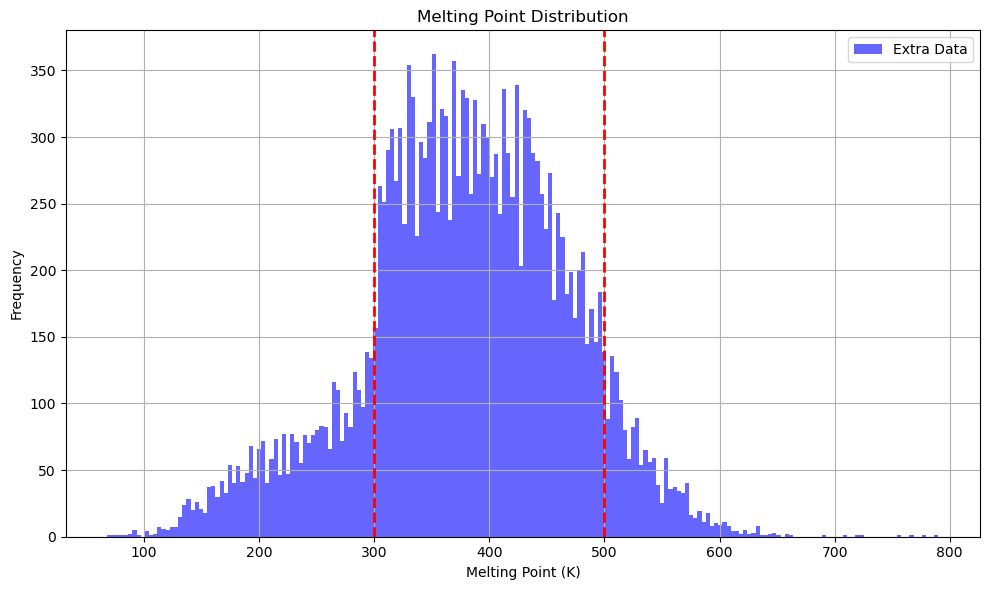

Tm
[300, 500)     14627
[0, 300)        3025
[500, 1000)     1531
Name: count, dtype: int64


In [5]:
# Plot histogram of Tm values from df_data and df_test
plt.figure(figsize=(10, 6))

plt.hist(df_data['Tm'], bins=200, alpha=0.6, label='Extra Data', color='blue')
plt.xlabel('Melting Point (K)')
plt.ylabel('Frequency')
plt.title('Melting Point Distribution')
plt.legend()
plt.grid(True)
plt.axvline(x=300, color='red', linestyle='--', linewidth=2, label='x=300')
plt.axvline(x=500, color='red', linestyle='--', linewidth=2, label='x=500')
plt.tight_layout()
plt.show()

bin_edges = [0, 300, 500, 1000]

counts = pd.cut(df_data['Tm'], bins=bin_edges, right=False).value_counts()
print(counts)

## 5. Feature Generation and Selection

To build effective models, we convert SMILES strings into molecular descriptors using RDKit's built-in descriptor functions. We exclude certain descriptors known to be less informative or problematic.

Next, we use a Random Forest classifier to compute feature importances and select the top features that cumulatively explain 95% of the importance. This reduces dimensionality and helps improve model performance.


In [6]:
# Load cleaned large dataset
df = pd.read_csv('data/processed/cleaned_extra_data.csv')

# Define bin edges and labels (from previous analysis)
bin_edges = [0, 300, 500, 1000]
bin_labels = [0, 1, 2] # 0: low, 1: medium, 2: high

# Bin melting points for classification task
df['Tm_bin'] = pd.cut(df['Tm'], bins=bin_edges, labels=bin_labels, include_lowest=True).astype(int)

# Get descriptor functions excluding some
descriptor_funcs = get_rdkit_descriptors()

# Featurize dataset (compute descriptors)
feature_df, valid_indices = featurize_smiles_dataframe(df, 'SMILES', descriptor_funcs)

# Keep only rows successfully featurized
df = df.loc[valid_indices].reset_index(drop=True)

# Prepare feature matrix and labels for feature importance
X = feature_df.values
y = df['Tm_bin']

# Compute feature importances and select top features explaining 95% cumulative importance
top_features_df = compute_feature_importance(X, y, feature_df.columns.tolist(), threshold=0.95)

# List of selected feature names
top_features = top_features_df['Feature'].tolist()
top_feature_data = feature_df[top_features].reset_index(drop=True)

# Concatenate base df with top features in one operation
df = pd.concat([df.reset_index(drop=True), top_feature_data.reset_index(drop=True)], axis=1)

# Optional: de-fragment DataFrame for best performance
df = df.copy()


print(f"Selected top {len(top_features)} features out of {len(feature_df.columns)} total features.")


Featurizing: 100%|██████████| 19183/19183 [01:27<00:00, 218.01it/s]


Selected top 115 features out of 211 total features.


### Summary

- Generated molecular descriptors from SMILES strings for all compounds.
- Filtered dataset to include only valid descriptor calculations.
- Binned melting points into three categories: Low, Medium, High.
- Selected the top ~95% most important features using a Random Forest classifier.

These features will be used in the subsequent modeling steps to train bin-specific regressors.


## 6. Classification of Melting Point Bins

### Why Classification?

Predicting exact melting points for organic compounds is challenging due to experimental noise and chemical complexity. Grouping melting points into bins—low, medium, and high—simplifies the problem and enables more robust and practical predictions for downstream tasks such as compound screening and material design.

### Model Choices

We use two complementary classification approaches:

- **XGBoost Classifier:** A powerful gradient boosting method well-suited for tabular chemical descriptor data, offering interpretability via feature importance.
- **Multi-Layer Perceptron (MLP):** A flexible neural network model capable of capturing complex, non-linear relationships in the data.

Combining their predictions in an ensemble aims to leverage their individual strengths and improve overall predictive accuracy.

### 6.1 Data Preparation

The dataset is split into training, validation, and test sets with stratification to maintain class balance. For the MLP, features are standardized using `StandardScaler` to zero mean and unit variance, which facilitates faster and more stable training convergence.

We wrap the datasets into PyTorch DataLoader objects for efficient batch processing.

### 6.2 XGBoost Classifier Training

Using the top molecular descriptors, we train XGBoost classifiers with hyperparameter tuning to optimize model performance. The grid search explores combinations of tree depth, number of estimators, and learning rate. The best model is evaluated on a held-out test set.

### 6.3 MLP Classifier Training

The MLP is trained using mini-batch gradient descent with early stopping to prevent overfitting. We monitor validation loss and stop training when no improvement is observed over 10 epochs.

### Expected Outcomes

- Achieve robust classification performance on melting point bins with both models.
- Address class imbalance challenges, especially for the high melting point bin.
- Prepare for ensemble modeling to combine strengths of both classifiers.

### Notes

- The dataset’s class imbalance may influence per-class performance.
- Feature scaling is critical for neural network convergence.
- Early stopping prevents overfitting during MLP training.


In [7]:
# Imports
from src.modeling.classifier import (
    train_multiclass_classifier,
    plot_classification_report,
    MLPClassifier,
    train_mlp_classifier,
    evaluate_model,
    train_ensemble_weights,
    ensemble_probabilities,
    prepare_data,
    MolDataset
)

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 6.1 Data Preparation

In [8]:
target_col = 'Tm_bin'

X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data(df, top_features, target_col)

train_dataset = MolDataset(X_train, y_train)
val_dataset = MolDataset(X_val, y_val)
test_dataset = MolDataset(X_test, y_test)


## 6.2 XGBoost Classifiers Per Melting Point Bin

--NOTE--
A hyperparameter grid was defined for the XGBoost classifiers. Below is an example of what a param_grid would look like. For brevity, the best features will be loaded in the final model.


Using the previously selected top features, we append these features to our main dataset and perform classification within each melting point bin. The per_bin_classification utility performs hyperparameter tuning via grid search and evaluates the models on a test split.

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Test Accuracy: 0.883
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       605
           1       0.90      0.95      0.93      2925
           2       0.69      0.40      0.50       306

    accuracy                           0.88      3836
   macro avg       0.81      0.72      0.75      3836
weighted avg       0.88      0.88      0.88      3836



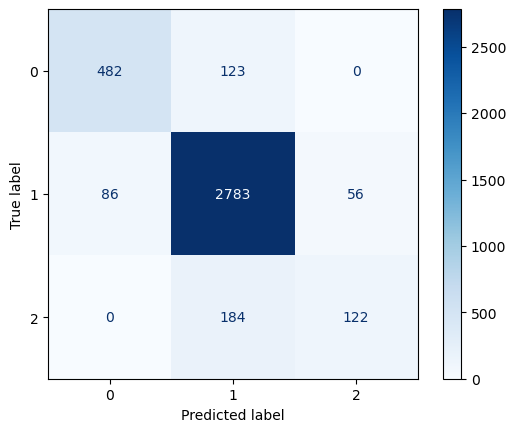

In [9]:
param_grid = {
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1]
}

xgb_model = train_multiclass_classifier(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    param_grid=param_grid
)

## 6.2.1 Evaluation of the Best XGB Model

After training multiple parameter grid searches, I selected the best-performing model based on validation performance and test accuracy. The final selected model used the following configuration:

```python
# TRUE PARAMETERS FOR XGBCLASSIFIER
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42,
    max_depth=7,
    learning_rate=0.011,
    n_estimators=300,
    subsample=0.7,
    colsample_bytree=0.9,
    gamma=0.9
)
```




Test Accuracy: 0.884
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       605
           1       0.90      0.95      0.93      2925
           2       0.68      0.40      0.50       306

    accuracy                           0.88      3836
   macro avg       0.81      0.72      0.75      3836
weighted avg       0.88      0.88      0.88      3836



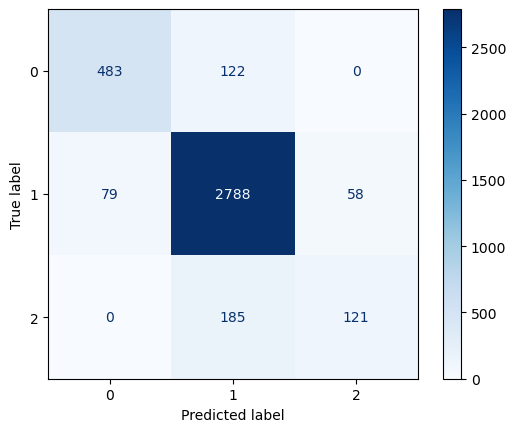

In [10]:

xgb_model = train_multiclass_classifier(
    X_train, X_val, X_test,
    y_train, y_val, y_test
)

xgb_clf = xgb_model['model']

## 6.3 Training an MLP Classifier on Melting Point Bins

We split the data into training, validation, and test sets with stratification, then wrap them in PyTorch DataLoaders for efficient training.

An MLP classifier is initialized with the input feature size and output classes. To optimize performance, we run a hyperparameter search over a param_grid with different options:
- Amount of hidden layers (Depth of the network)
- Amount of nodes per hidden layer (Width of the network) 
- Activation functions (silu, tanh, gelu, relu, softplus)
- Dropout rate

For each configuration, we train the model with early stopping, evaluate on the test set, and record the accuracy. Finally, the best model and parameters are reported.

Below is the code for this process:




Training with params: {'hidden_layers': (128, 256, 128, 256, 128), 'activation': 'silu'}
Early stopping at epoch 87
Test Accuracy: 0.874
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       605
           1       0.90      0.94      0.92      2925
           2       0.61      0.39      0.47       306

    accuracy                           0.87      3836
   macro avg       0.78      0.71      0.74      3836
weighted avg       0.87      0.87      0.87      3836



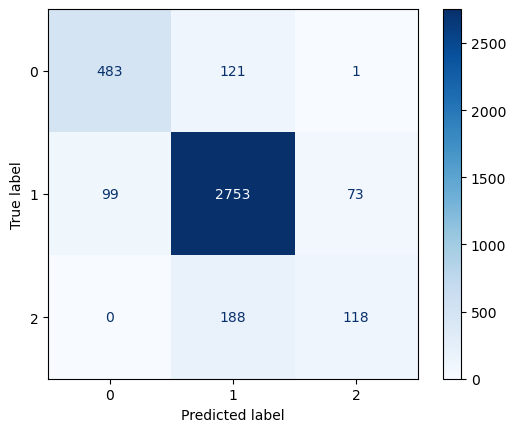


Training with params: {'hidden_layers': (32, 32), 'activation': 'tanh'}
Test Accuracy: 0.864
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       605
           1       0.89      0.94      0.91      2925
           2       0.60      0.33      0.43       306

    accuracy                           0.86      3836
   macro avg       0.77      0.68      0.71      3836
weighted avg       0.85      0.86      0.86      3836



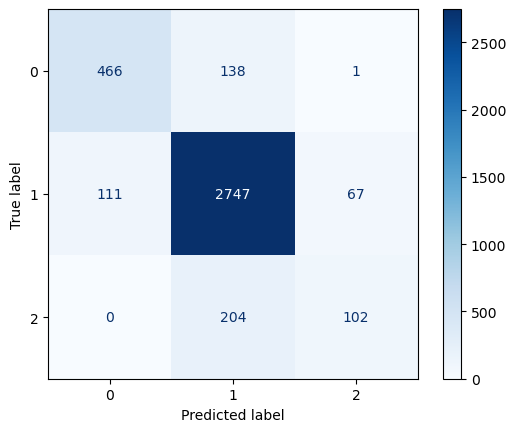

Best parameters: {'hidden_layers': (128, 256, 128, 256, 128), 'activation': 'silu'}
Test accuracy: 0.874


In [11]:
# Variables
results = []
batch_size = 32
epochs = 150
lr = 1e-4
patience = 30
    
# Prepare dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

# parameters to search
param_grid = [
    {'hidden_layers': (128, 256, 128, 256, 128), 'activation': 'silu'},
    {'hidden_layers': (32, 32), 'activation': 'tanh'},
]

for params in param_grid:
    print(f"\nTraining with params: {params}")
    model = MLPClassifier(
        input_dim=input_dim,
        num_classes=num_classes,
        hidden_layers=params['hidden_layers'],
        activation=params.get('activation', 'silu'),
        dropout=0.3
    ).to(device)
    
    model = train_mlp_classifier(
        model,
        train_loader,
        val_loader,
        epochs=epochs,
        lr=lr,
        patience=patience
    )
    
    acc, y_true, y_pred = evaluate_model(model, test_loader)
    print(f"Test Accuracy: {acc:.3f}")
    
    plot_classification_report(y_test, y_pred)
    
    results.append({'params': params, 'accuracy': acc, 'model': model})


best_result = max(results, key=lambda x: x['accuracy'])
print(f"Best parameters: {best_result['params']}")
print(f"Test accuracy: {best_result['accuracy']:.3f}")


## 6.3.1 Evaluation of the Best MLP Model

After training multiple MLP architectures, I selected the best-performing model based on validation performance and test accuracy. The final selected model used the following configuration:

```python
# TRUE PARAMETERS FOR MLPClassifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.drop1 = nn.Dropout(0.30)
        self.fc2 = nn.Linear(128, 512)
        self.drop2 = nn.Dropout(0.30)
        self.fc3 = nn.Linear(512, 512)
        self.drop3 = nn.Dropout(0.30)
        self.fc4 = nn.Linear(512, 128)
        self.drop4 = nn.Dropout(0.30)
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = self.drop1(x)
        x = F.silu(self.fc2(x))
        x = self.drop2(x)
        x = F.silu(self.fc3(x))
        x = self.drop3(x)
        x = F.silu(self.fc4(x))
        x = self.drop4(x)
        return self.output(x)
```

Early stopping at epoch 60
MLP Classification Report
Test Accuracy: 0.878
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       605
           1       0.90      0.94      0.92      2925
           2       0.64      0.41      0.50       306

    accuracy                           0.88      3836
   macro avg       0.79      0.72      0.75      3836
weighted avg       0.87      0.88      0.87      3836



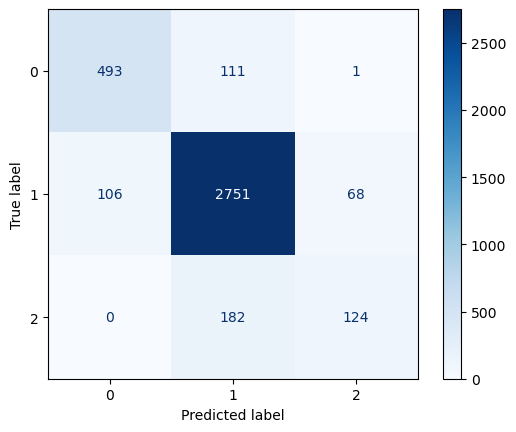

In [12]:
mlp_model = MLPClassifier(input_dim=input_dim).to(device)
    
mlp_model = train_mlp_classifier(mlp_model, train_loader, val_loader)

print("MLP Classification Report")
acc, y_true, y_pred = evaluate_model(mlp_model, test_loader)
print(f"Test Accuracy: {acc:.3f}")
plot_classification_report(y_true, y_pred)

Optimized weights per class: [0.5 0.5 0.5]
Ensemble Accuracy: 0.883
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82       605
           1       0.90      0.96      0.93      2925
           2       0.72      0.39      0.51       306

    accuracy                           0.88      3836
   macro avg       0.82      0.71      0.75      3836
weighted avg       0.88      0.88      0.87      3836



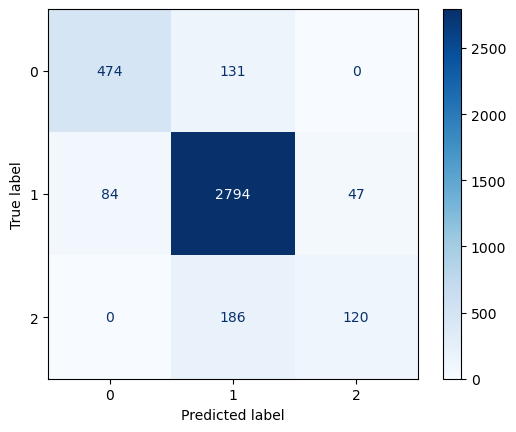

In [13]:
# For MLP
mlp_model.eval()
mlp_probs = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        mlp_probs.append(probs.cpu().numpy())

mlp_probs = np.vstack(mlp_probs)

# For XGBoost
xgb_probs = xgb_clf.predict_proba(X_test)

ensemble_weights = train_ensemble_weights(mlp_probs, xgb_probs, y_test)
print("Optimized weights per class:", ensemble_weights)

ensemble_probs = ensemble_weights * mlp_probs + (1 - ensemble_weights) * xgb_probs
y_pred_ensemble = np.argmax(ensemble_probs, axis=1)
ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Accuracy: {ensemble_acc:.3f}")
print("Classification Report:")
plot_classification_report(y_test, y_pred_ensemble)

In [ ]:
# Imports
from src.modeling.regressors import (
    plot_regression_predictions,
    grid_search_per_bin
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from typing import Dict, List, Optional, Any

In [ ]:
# Define your broad parameter grids for each bin
broad_param_grids = {
    0: {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 300],
    },
    1: {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 300],
    },
    2: {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 300],
    }
}

# Perform broad grid search
broad_search_results = grid_search_per_bin(
    df=your_dataframe,
    features=your_feature_columns,
    param_grids=broad_param_grids,
    bin_col='Tm_bin',
    target_col='Tm'
)



In [ ]:
refined_param_grids = {
    0: {
        'max_depth': [4, 5],
        'learning_rate': [0.015, 0.02, 0.03],
        'n_estimators': [500, 600, 700],
    },
    1: {
        'max_depth': [4, 5],
        'learning_rate': [0.01, 0.02, 0.03],
        'n_estimators': [300, 400, 500],
    },
    2: {
        'max_depth': [3, 4],
        'learning_rate': [0.015, 0.025],
        'n_estimators': [400, 500, 600],
    }
}

refined_search_results = grid_search_per_bin(
    df=your_dataframe,
    features=your_feature_columns,
    param_grids=refined_param_grids,
    bin_col='Tm_bin',
    target_col='Tm'
)
